In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


/home/strrl/Project/7375/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-13 12:59:01.533515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 12:59:03.137006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749844743.634529    8578 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749844743.776185    8578 cuda_blas.cc:1407] 

In [8]:
file_path = "code-review-dataset-full.xlsx"

df = pd.read_excel(file_path)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

toxicity_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, top_k=None)


Device set to use cuda:0


In [10]:
print(model.device)

cuda:0


In [11]:
df = df.dropna(subset=['message','is_toxic'])
df['message'] = df['message'].astype(str)

In [ ]:
def get_toxic_score(text):
    try:
        outputs = toxicity_pipe(text, truncation=True)[0]
        for result in outputs:
            if result['label'].lower() == 'toxic':
                return result['score']
        return 0.0
    except Exception as e:
        print("Error on text:", text)
        print(e)
        return 0.0


In [18]:
df_sample = df.copy()

messages = df_sample['message'].tolist()

results = toxicity_pipe(messages, batch_size=8, truncation=True)

def extraxt_toxic_score(result):
    for label_score in result:
        if label_score['label'].lower() == 'toxic':
            return label_score['score']
    return 0.0

df_sample['toxic_score'] = [extraxt_toxic_score(result) for result in results]


In [19]:
threshold = 0.5
df_sample['pred_label'] = df_sample['toxic_score'] > threshold

y_true = df_sample["is_toxic"]
y_pred = df_sample["pred_label"]
y_prob = df_sample["toxic_score"]

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("ROC AUC:", roc_auc_score(y_true, y_prob))

precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

print("PR AUC:", pr_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     15890
           1       0.66      0.35      0.46      3757

    accuracy                           0.84     19647
   macro avg       0.76      0.65      0.68     19647
weighted avg       0.82      0.84      0.82     19647

ROC AUC: 0.8562784668953595
PR AUC: 0.603390372071745


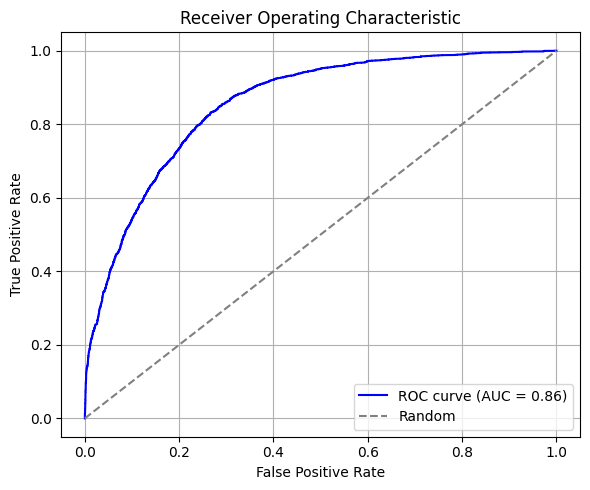

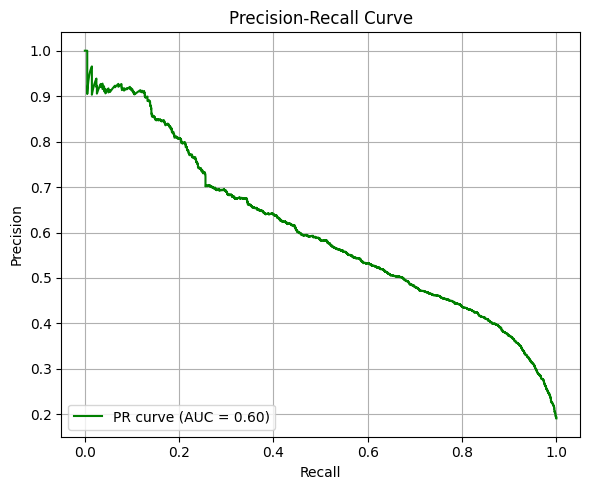

In [20]:
# ROC curve

import matplotlib.pyplot as plt

# get ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# plot PR curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

